# MNIST Digit Recognition with Convolutional Neural Networks

## Project Overview


**Technical Description:**
This notebook implements a Convolutional Neural Network (CNN) for recognizing handwritten digits from the MNIST dataset. CNNs are particularly effective for image classification tasks because they can automatically learn spatial hierarchies of features. We'll achieve >95% test accuracy using TensorFlow/Keras.

**Target Accuracy:** >95%

## 1. Import Libraries and Setup

In [ ]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Scikit-learn for evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directories
os.makedirs('outputs', exist_ok=True)
os.makedirs('outputs/saved_model', exist_ok=True)



MNIST CNN - HANDWRITTEN DIGIT RECOGNITION

✓ All libraries imported successfully!
✓ TensorFlow version: 2.20.0
✓ Keras version: 3.11.3
✓ Random seeds set to 42 for reproducibility
✓ Output directories created


## 2. Load and Explore MNIST Dataset

In [18]:
# Load the dataset
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = mnist.load_data()

print(f"   Training Images:   {X_train_raw.shape} → {X_train_raw.shape[0]:,} images")
print(f"   Training Labels:   {y_train_raw.shape} → {y_train_raw.shape[0]:,} labels")
print(f"   Test Images:       {X_test_raw.shape} → {X_test_raw.shape[0]:,} images")
print(f"   Test Labels:       {y_test_raw.shape} → {y_test_raw.shape[0]:,} labels")

print(f"   Total Images:      {X_train_raw.shape[0] + X_test_raw.shape[0]:,}")

# Check class distribution
print(f"\n Class Distribution in Training Set:")
unique, counts = np.unique(y_train_raw, return_counts=True)
for digit, count in zip(unique, counts):
    percentage = (count / len(y_train_raw)) * 100
    bar = '█' * int(percentage / 2)
    print(f"   Digit {digit}: {count:>5,} samples ({percentage:>5.2f}%) {bar}")

   Training Images:   (60000, 28, 28) → 60,000 images
   Training Labels:   (60000,) → 60,000 labels
   Test Images:       (10000, 28, 28) → 10,000 images
   Test Labels:       (10000,) → 10,000 labels
   Total Images:      70,000

 Class Distribution in Training Set:
   Digit 0: 5,923 samples ( 9.87%) ████
   Digit 1: 6,742 samples (11.24%) █████
   Digit 2: 5,958 samples ( 9.93%) ████
   Digit 3: 6,131 samples (10.22%) █████
   Digit 4: 5,842 samples ( 9.74%) ████
   Digit 5: 5,421 samples ( 9.04%) ████
   Digit 6: 5,918 samples ( 9.86%) ████
   Digit 7: 6,265 samples (10.44%) █████
   Digit 8: 5,851 samples ( 9.75%) ████
   Digit 9: 5,949 samples ( 9.92%) ████


## 3. Visualize Sample Images

 Sample visualization saved to: outputs/sample_digits.png


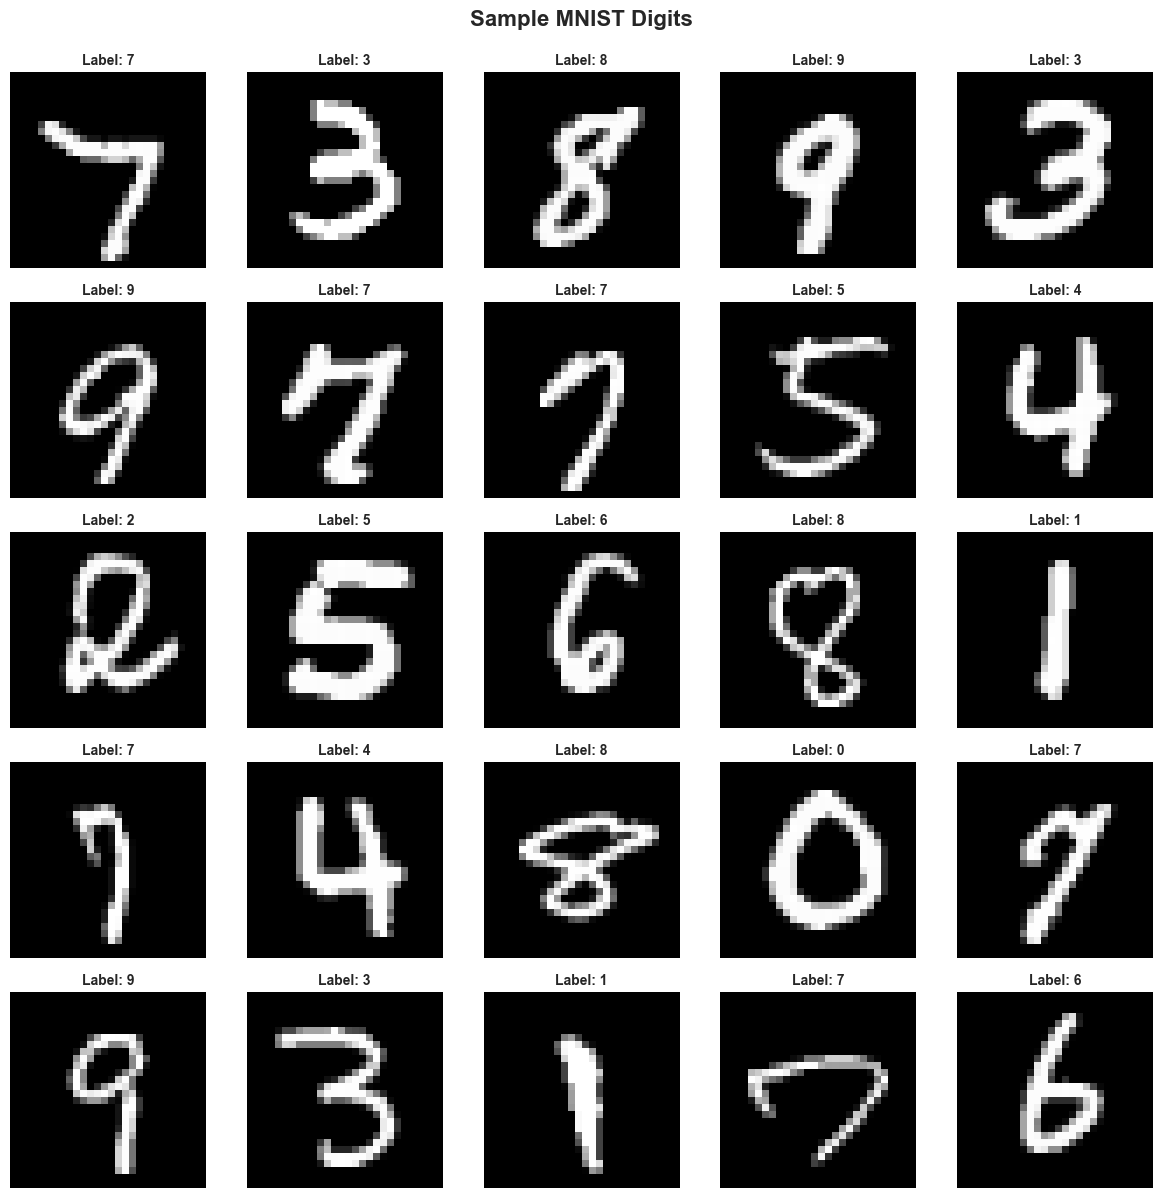

In [19]:
# Select random samples
n_samples = 25
indices = np.random.choice(len(X_train_raw), n_samples, replace=False)

# Create figure
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
axes = axes.ravel()

for idx, ax in enumerate(axes):
    # Display image
    ax.imshow(X_train_raw[indices[idx]], cmap='gray')
    ax.set_title(f'Label: {y_train_raw[indices[idx]]}', fontsize=10, fontweight='bold')
    ax.axis('off')
    
    # Add colored border
    for spine in ax.spines.values():
        spine.set_edgecolor(plt.cm.tab10(y_train_raw[indices[idx]]))
        spine.set_linewidth(2)
        spine.set_visible(True)

plt.suptitle('Sample MNIST Digits', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('outputs/sample_digits.png', dpi=300, bbox_inches='tight')
print(f" Sample visualization saved to: outputs/sample_digits.png")
plt.show()

## 4. Data Preprocessing

In [20]:
# Step 1: Reshape data for CNN (add channel dimension)
print(f"\n Step 1: Reshaping Data")
print(f"   Original shape: {X_train_raw.shape}")

X_train = X_train_raw.reshape(-1, 28, 28, 1).astype('float32')
X_test = X_test_raw.reshape(-1, 28, 28, 1).astype('float32')

print(f"   New shape:      {X_train.shape}")
print(f"   Explanation:    (samples, height, width, channels)")


 Step 1: Reshaping Data
   Original shape: (60000, 28, 28)
   New shape:      (60000, 28, 28, 1)
   Explanation:    (samples, height, width, channels)


**NOTES**


- CNNs expect input in the format `(batch_size, height, width, channels)`. 

- Channels in this case mean whether the image is in `grayscale`, black and white(**1 channels**) or `RGB`, **3 channels**. 

- We add the fourth parameter, channels to satisfy the CNNs expected input. 

In [21]:
# Step 2: Normalize pixel values to [0, 1]
print(f"\n Step 2: Normalizing Pixel Values")
print(f"   Original range: [{X_train.min():.0f}, {X_train.max():.0f}]")

X_train = X_train / 255.0
X_test = X_test / 255.0

print(f"   New range:      [{X_train.min():.4f}, {X_train.max():.4f}]")


 Step 2: Normalizing Pixel Values
   Original range: [0, 255]
   New range:      [0.0000, 1.0000]
   New range:      [0.0000, 1.0000]


**NOTES**:

- Images thave pixel values and for grayscale images that value ranges from: 
    
    - 0 = Pure white (no color at all)

    - 128 = Medium gray (halfway dark)

    - 255 = Pure black (darkest possible)

- We normalize to convert these values into probabilities betweel 0- no color to 1- all color. 

**Why?**:

*Faster training speed* and *better accuracy*. 

In [22]:
# Step 3: Create validation split (10% of training data)
print(f"\n Step 3: Creating Validation Split")
validation_split = 0.1
val_size = int(len(X_train) * validation_split)

# Shuffle and split
indices = np.random.permutation(len(X_train))
train_indices = indices[val_size:]
val_indices = indices[:val_size]

X_val = X_train[val_indices]
y_val_raw = y_train_raw[val_indices]
X_train = X_train[train_indices]
y_train = y_train_raw[train_indices]

print(f"   Training samples:   {len(X_train):,}")
print(f"   Validation samples: {len(X_val):,}")
print(f"   Test samples:       {len(X_test):,}")


 Step 3: Creating Validation Split
   Training samples:   54,000
   Validation samples: 6,000
   Test samples:       10,000
   Training samples:   54,000
   Validation samples: 6,000
   Test samples:       10,000


In [23]:
# Step 4: One-hot encode labels
print(f"\n Step 4: One-Hot Encoding Labels")
print(f"   Original label example: {y_train[0]}")

y_train_cat = to_categorical(y_train, 10)
y_val_cat = to_categorical(y_val_raw, 10)
y_test_cat = to_categorical(y_test_raw, 10)

print(f"   One-hot encoded:        {y_train_cat[0]}")
print(f"   Shape:                  {y_train_cat.shape}")


 Step 4: One-Hot Encoding Labels
   Original label example: 6
   One-hot encoded:        [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
   Shape:                  (54000, 10)


**NOTES:**

- We perform one-hot encoding of the lables because regular labels treat digits as numbers with magnitude but for our case, the digits are simply individual values with no relationship. 

**WHY?:**

- Regular labels treat digits as numbers with magnitude
- One-hot encoding treats digits as distinct categories
- Neural networks need the one-hot format to learn classification properly!

## 5. Build CNN Architecture
**Technical Explanation:**
We'll build a CNN with the following architecture:
- 3 Convolutional blocks (Conv2D → MaxPooling → Dropout)
- Progressively increasing filters (32 → 64 → 128)
- Flatten and Dense layers for classification
- Dropout for regularization to prevent overfitting
- Softmax activation for multi-class classification

In [24]:
# Build CNN model
model = keras.Sequential([
    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same', name='conv1'),
    layers.BatchNormalization(name='bn1'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2'),
    layers.BatchNormalization(name='bn2'),
    layers.MaxPooling2D((2, 2), name='pool1'),
    layers.Dropout(0.25, name='dropout1'),
    
    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv3'),
    layers.BatchNormalization(name='bn3'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv4'),
    layers.BatchNormalization(name='bn4'),
    layers.MaxPooling2D((2, 2), name='pool2'),
    layers.Dropout(0.25, name='dropout2'),
    
    # Convolutional Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv5'),
    layers.BatchNormalization(name='bn5'),
    layers.MaxPooling2D((2, 2), name='pool3'),
    layers.Dropout(0.25, name='dropout3'),
    
    # Flatten and Dense Layers
    layers.Flatten(name='flatten'),
    layers.Dense(256, activation='relu', name='dense1'),
    layers.BatchNormalization(name='bn6'),
    layers.Dropout(0.5, name='dropout4'),
    layers.Dense(128, activation='relu', name='dense2'),
    layers.Dropout(0.5, name='dropout5'),
    layers.Dense(10, activation='softmax', name='output')
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

print(f"\n Model Built Successfully!")
print(f"\n Model Configuration:")
print(f"   Input Shape:        (28, 28, 1)")
print(f"   Output Classes:     10")
print(f"   Optimizer:          Adam (lr=0.001)")
print(f"   Loss Function:      Categorical Crossentropy")


model.summary()

# Save model architecture diagram
print(f"\n Saving Model Architecture Diagram...")
try:
    plot_model(model, to_file='outputs/model_architecture.png', show_shapes=True, 
               show_layer_names=True, rankdir='TB', dpi=150)
    print(f" Architecture saved to: outputs/model_architecture.png")
except:
    print(f" Could not save diagram (graphviz may not be installed)")


 Model Built Successfully!

 Model Configuration:
   Input Shape:        (28, 28, 1)
   Output Classes:     10
   Optimizer:          Adam (lr=0.001)
   Loss Function:      Categorical Crossentropy


c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 28, 28, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 28, 28, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 14, 14, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 14, 14, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 7, 7, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn6 (BatchNormalization)        │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout4 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout5 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 470,506 (1.79 MB)

 Trainable params: 469,354 (1.79 MB)

 Non-trainable params: 1,152 (4.50 KB)


 Saving Model Architecture Diagram...
You must install pydot (`pip install pydot`) for `plot_model` to work.
 Architecture saved to: outputs/model_architecture.png
 Architecture saved to: outputs/model_architecture.png


**NOTES:**
- CNNs have multiple layers with different funtions. We need to set up these layers before training our model. 

- CNNs work with the following layers:
     - **Convolution Layer**: To detect important features and recognize patterns in images. The key parameter is the number of filters (32,64,128).
     - **Batch Normalization Layer**: It's purpose is to normalize activations to create stability or the model as it learns from the data. 
     - **MaxPooling Layer**: It reduces image size while retaining the most important features and makes the network more robust to small variations in position. 
     - **Dropout Layer:** Purposefully forgets some of the learned data, it is a form of regularization that prevents overfitting.
     - **Flatten Layer:** Converts the feature maps(`height x width x channels`) from 3D to 1D vector that the Dense layers can process 
     - **Dense:** This are fully connected layers that learn high level patersn and make the final decisions.The final dense layer has one neuron per class and uses softmax activation to output probabilities. 

## 6. Configure Training Callbacks

Callbacks enhance training efficiency and prevent overfitting:
- **EarlyStopping**: Monitors validation loss and stops training if no improvement
- **ModelCheckpoint**: Saves the best model weights based on validation accuracy
- **ReduceLROnPlateau**: Reduces learning rate when validation loss plateaus

In [25]:
# Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1,
    mode='min'
)
print(f"\n Early Stopping: monitor='val_loss', patience=5")

# Model Checkpoint
checkpoint = ModelCheckpoint(
    filepath='outputs/saved_model/best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
print(f"Model Checkpoint: saves best model to outputs/saved_model/best_model.h5")

# Reduce Learning Rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)
print(f"Reduce LR: reduces learning rate by 0.5 when validation loss plateaus")

callbacks = [early_stop, checkpoint, reduce_lr]


 Early Stopping: monitor='val_loss', patience=5
Model Checkpoint: saves best model to outputs/saved_model/best_model.h5
Reduce LR: reduces learning rate by 0.5 when validation loss plateaus


## 7. Train the Model

Training involves forward propagation (making predictions), calculating loss, backward propagation (computing gradients), and updating weights. We use batch processing for efficiency and monitor both training and validation metrics to detect overfitting.

In [26]:
# Training configuration
epochs = 20
batch_size = 64

print(f"\n Training Configuration:")
print(f"   Epochs:           {epochs}")
print(f"   Batch Size:       {batch_size}")
print(f"   Training samples: {len(X_train):,}")
print(f"   Validation samples: {len(X_val):,}")

print(f"\n Starting training...")
print(f"   Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

start_time = datetime.now()

# Train the model
history = model.fit(
    X_train, y_train_cat,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val_cat),
    callbacks=callbacks,
    verbose=1
)

end_time = datetime.now()
training_duration = end_time - start_time

print(f" Training Complete!")
print(f"   Duration: {training_duration}")
print(f"   Epochs completed: {len(history.history['loss'])}")

# Display final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"\n Final Training Metrics:")
print(f"   Training Accuracy:     {final_train_acc:.4f}")
print(f"   Validation Accuracy:   {final_val_acc:.4f}")

if final_val_acc >= 0.95:
    print(f"\n SUCCESS! Validation accuracy {final_val_acc:.4f} exceeds 95% target!")


 Training Configuration:
   Epochs:           20
   Batch Size:       64
   Training samples: 54,000
   Validation samples: 6,000

 Starting training...
   Start time: 2025-10-27 10:35:08
Epoch 1/20
Epoch 1/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.7645 - loss: 0.7881 - precision_2: 0.8275 - recall_2: 0.7204
Epoch 1: val_accuracy improved from None to 0.98350, saving model to outputs/saved_model/best_model.h5

Epoch 1: val_accuracy improved from None to 0.98350, saving model to outputs/saved_model/best_model.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 212s 245ms/step - accuracy: 0.8923 - loss: 0.3544 - precision_2: 0.9254 - recall_2: 0.8717 - val_accuracy: 0.9835 - val_loss: 0.0634 - val_precision_2: 0.9841 - val_recall_2: 0.9815 - learning_rate: 0.0010
Epoch 2/20
Epoch 2/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9658 - loss: 0.1124 - precision_2: 0.9711 - recall_2: 0.9619
Epoch 2: val_accuracy improved from 0.98350 to 0.98783, saving model to outputs/saved_model/best_model.h5

Epoch 2: val_accuracy improved from 0.98350 to 0.98783, saving model to outputs/saved_model/best_model.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 207s 246ms/step - accuracy: 0.9700 - loss: 0.1012 - precision_2: 0.9744 - recall_2: 0.9666 - val_accuracy: 0.9878 - val_loss: 0.0437 - val_precision_2: 0.9880 - val_recall_2: 0.9870 - learning_rate: 0.0010
Epoch 3/20
Epoch 3/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9754 - loss: 0.0849 - precision_2: 0.9784 - recall_2: 0.9727
Epoch 3: val_accuracy improved from 0.98783 to 0.98850, saving model to outputs/saved_model/best_model.h5

Epoch 3: val_accuracy improved from 0.98783 to 0.98850, saving model to outputs/saved_model/best_model.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 211s 250ms/step - accuracy: 0.9778 - loss: 0.0771 - precision_2: 0.9803 - recall_2: 0.9755 - val_accuracy: 0.9885 - val_loss: 0.0385 - val_precision_2: 0.9901 - val_recall_2: 0.9880 - learning_rate: 0.0010
Epoch 4/20
Epoch 4/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9804 - loss: 0.0674 - precision_2: 0.9836 - recall_2: 0.9778
Epoch 4: val_accuracy improved from 0.98850 to 0.98867, saving model to outputs/saved_model/best_model.h5

Epoch 4: val_accuracy improved from 0.98850 to 0.98867, saving model to outputs/saved_model/best_model.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 217s 257ms/step - accuracy: 0.9821 - loss: 0.0622 - precision_2: 0.9846 - recall_2: 0.9799 - val_accuracy: 0.9887 - val_loss: 0.0400 - val_precision_2: 0.9893 - val_recall_2: 0.9875 - learning_rate: 0.0010
Epoch 5/20
Epoch 5/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9829 - loss: 0.0574 - precision_2: 0.9848 - recall_2: 0.9812
Epoch 5: val_accuracy did not improve from 0.98867
844/844 ━━━━━━━━━━━━━━━━━━━━ 235s 278ms/step - accuracy: 0.9836 - loss: 0.0558 - precision_2: 0.9854 - recall_2: 0.9821 - val_accuracy: 0.9885 - val_loss: 0.0355 - val_precision_2: 0.9898 - val_recall_2: 0.9878 - learning_rate: 0.0010

Epoch 5: val_accuracy did not improve from 0.98867
844/844 ━━━━━━━━━━━━━━━━━━━━ 235s 278ms/step - accuracy: 0.9836 - loss: 0.0558 - precision_2: 0.9854 - recall_2: 0.9821 - val_accuracy: 0.9885 - val_loss: 0.0355 - val_precision_2: 0.9898 - val_recall_2: 0.9878 - learning_rate: 0.0010
Epoch 6/20
Epoch 6/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 0

844/844 ━━━━━━━━━━━━━━━━━━━━ 246s 291ms/step - accuracy: 0.9858 - loss: 0.0489 - precision_2: 0.9876 - recall_2: 0.9844 - val_accuracy: 0.9907 - val_loss: 0.0318 - val_precision_2: 0.9912 - val_recall_2: 0.9903 - learning_rate: 0.0010
Epoch 7/20
Epoch 7/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9861 - loss: 0.0460 - precision_2: 0.9879 - recall_2: 0.9849
Epoch 7: val_accuracy did not improve from 0.99067
844/844 ━━━━━━━━━━━━━━━━━━━━ 247s 293ms/step - accuracy: 0.9871 - loss: 0.0433 - precision_2: 0.9885 - recall_2: 0.9859 - val_accuracy: 0.9907 - val_loss: 0.0371 - val_precision_2: 0.9908 - val_recall_2: 0.9905 - learning_rate: 0.0010

Epoch 7: val_accuracy did not improve from 0.99067
844/844 ━━━━━━━━━━━━━━━━━━━━ 247s 293ms/step - accuracy: 0.9871 - loss: 0.0433 - precision_2: 0.9885 - recall_2: 0.9859 - val_accuracy: 0.9907 - val_loss: 0.0371 - val_precision_2: 0.9908 - val_recall_2: 0.9905 - learning_rate: 0.0010
Epoch 8/20
Epoch 8/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 0

844/844 ━━━━━━━━━━━━━━━━━━━━ 284s 336ms/step - accuracy: 0.9879 - loss: 0.0423 - precision_2: 0.9896 - recall_2: 0.9866 - val_accuracy: 0.9918 - val_loss: 0.0318 - val_precision_2: 0.9927 - val_recall_2: 0.9917 - learning_rate: 0.0010
Epoch 9/20
Epoch 9/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9893 - loss: 0.0401 - precision_2: 0.9906 - recall_2: 0.9879
Epoch 9: val_accuracy did not improve from 0.99183

Epoch 9: val_accuracy did not improve from 0.99183
844/844 ━━━━━━━━━━━━━━━━━━━━ 250s 296ms/step - accuracy: 0.9894 - loss: 0.0380 - precision_2: 0.9908 - recall_2: 0.9881 - val_accuracy: 0.9915 - val_loss: 0.0303 - val_precision_2: 0.9922 - val_recall_2: 0.9910 - learning_rate: 0.0010
844/844 ━━━━━━━━━━━━━━━━━━━━ 250s 296ms/step - accuracy: 0.9894 - loss: 0.0380 - precision_2: 0.9908 - recall_2: 0.9881 - val_accuracy: 0.9915 - val_loss: 0.0303 - val_precision_2: 0.9922 - val_recall_2: 0.9910 - learning_rate: 0.0010
Epoch 10/20
Epoch 10/20
844/844 ━━━━━━━━━━━━━━━━━━━━

844/844 ━━━━━━━━━━━━━━━━━━━━ 271s 321ms/step - accuracy: 0.9897 - loss: 0.0358 - precision_2: 0.9907 - recall_2: 0.9886 - val_accuracy: 0.9925 - val_loss: 0.0269 - val_precision_2: 0.9933 - val_recall_2: 0.9925 - learning_rate: 0.0010
Epoch 11/20
Epoch 11/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9903 - loss: 0.0335 - precision_2: 0.9912 - recall_2: 0.9893
Epoch 11: val_accuracy improved from 0.99250 to 0.99400, saving model to outputs/saved_model/best_model.h5

Epoch 11: val_accuracy improved from 0.99250 to 0.99400, saving model to outputs/saved_model/best_model.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 246s 292ms/step - accuracy: 0.9907 - loss: 0.0318 - precision_2: 0.9917 - recall_2: 0.9899 - val_accuracy: 0.9940 - val_loss: 0.0240 - val_precision_2: 0.9942 - val_recall_2: 0.9932 - learning_rate: 0.0010
Epoch 12/20
Epoch 12/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9907 - loss: 0.0346 - precision_2: 0.9916 - recall_2: 0.9896
Epoch 12: val_accuracy did not improve from 0.99400

Epoch 12: val_accuracy did not improve from 0.99400
844/844 ━━━━━━━━━━━━━━━━━━━━ 243s 288ms/step - accuracy: 0.9910 - loss: 0.0322 - precision_2: 0.9919 - recall_2: 0.9901 - val_accuracy: 0.9928 - val_loss: 0.0252 - val_precision_2: 0.9932 - val_recall_2: 0.9927 - learning_rate: 0.0010
844/844 ━━━━━━━━━━━━━━━━━━━━ 243s 288ms/step - accuracy: 0.9910 - loss: 0.0322 - precision_2: 0.9919 - recall_2: 0.9901 - val_accuracy: 0.9928 - val_loss: 0.0252 - val_precision_2: 0.9932 - val_recall_2: 0.9927 - learning_rate: 0.0010
Epoch 13/20
Epoch 13/20
844/844 ━━━━━━━━━━━━━━━━

844/844 ━━━━━━━━━━━━━━━━━━━━ 241s 286ms/step - accuracy: 0.9945 - loss: 0.0176 - precision_2: 0.9950 - recall_2: 0.9940 - val_accuracy: 0.9945 - val_loss: 0.0224 - val_precision_2: 0.9948 - val_recall_2: 0.9943 - learning_rate: 5.0000e-04
Epoch 18/20
Epoch 18/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9953 - loss: 0.0158 - precision_2: 0.9957 - recall_2: 0.9945
Epoch 18: val_accuracy improved from 0.99450 to 0.99550, saving model to outputs/saved_model/best_model.h5

Epoch 18: val_accuracy improved from 0.99450 to 0.99550, saving model to outputs/saved_model/best_model.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 260s 308ms/step - accuracy: 0.9956 - loss: 0.0149 - precision_2: 0.9960 - recall_2: 0.9950 - val_accuracy: 0.9955 - val_loss: 0.0206 - val_precision_2: 0.9958 - val_recall_2: 0.9955 - learning_rate: 5.0000e-04
Epoch 19/20
Epoch 19/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9953 - loss: 0.0162 - precision_2: 0.9956 - recall_2: 0.9949
Epoch 19: val_accuracy did not improve from 0.99550
844/844 ━━━━━━━━━━━━━━━━━━━━ 260s 306ms/step - accuracy: 0.9954 - loss: 0.0149 - precision_2: 0.9958 - recall_2: 0.9951 - val_accuracy: 0.9950 - val_loss: 0.0216 - val_precision_2: 0.9953 - val_recall_2: 0.9948 - learning_rate: 5.0000e-04

Epoch 19: val_accuracy did not improve from 0.99550
844/844 ━━━━━━━━━━━━━━━━━━━━ 260s 306ms/step - accuracy: 0.9954 - loss: 0.0149 - precision_2: 0.9958 - recall_2: 0.9951 - val_accuracy: 0.9950 - val_loss: 0.0216 - val_precision_2: 0.9953 - val_recall_2: 0.9948 - learning_rate: 5.0000e-04
Epoch 20/20
Epoch 20/20
844/844 ━━━━

## 9. Evaluate on Test Set

In [27]:
print(f"\n Making predictions on {len(X_test):,} test images...")

# Get predictions
predictions = model.predict(X_test, verbose=0)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Calculate metrics
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test_cat, verbose=0)
test_f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\n Test Set Performance:")
print(f"   Test Accuracy:   {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Test Precision:  {test_precision:.4f}")
print(f"   Test Recall:     {test_recall:.4f}")
print(f"   Test F1-Score:   {test_f1:.4f}")
print(f"   Test Loss:       {test_loss:.4f}")
print(f"{'='*70}")

if test_accuracy >= 0.95:
    print(f"\n SUCCESS! Test accuracy {test_accuracy:.4f} exceeds 95% target!")

# Detailed classification report
print(f"\n Detailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(10)], digits=4))

# Per-class accuracy
print(f"\n Per-Class Accuracy:")
for digit in range(10):
    mask = y_true == digit
    digit_accuracy = (y_pred[mask] == digit).sum() / mask.sum()
    total_samples = mask.sum()
    bar = '█' * int(digit_accuracy * 50)
    print(f"   Digit {digit}: {digit_accuracy:.4f} ({total_samples:>4} samples) {bar}")


 Making predictions on 10,000 test images...

 Test Set Performance:
   Test Accuracy:   0.9957 (99.57%)
   Test Precision:  0.9958
   Test Recall:     0.9956
   Test F1-Score:   0.9957
   Test Loss:       0.0185

 SUCCESS! Test accuracy 0.9957 exceeds 95% target!

 Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9969    0.9969    0.9969       980
           1     0.9939    0.9991    0.9965      1135
           2     0.9952    0.9961    0.9956      1032
           3     0.9951    0.9980    0.9965      1010
           4     0.9949    0.9980    0.9964       982
           5     0.9955    0.9944    0.9950       892
           6     0.9979    0.9906    0.9942       958
           7     0.9951    0.9951    0.9951      1028
           8     0.9959    0.9959    0.9959       974
           9     0.9970    0.9921    0.9945      1009

    accuracy                         0.9957     10000
   macro avg     0.9957    0.9956    0.9957     10

## 10. Confusion Matrix Visualization

The confusion matrix visualizes classification performance across all classes. Diagonal elements represent correct predictions, while off-diagonal elements indicate misclassifications. This helps identify systematic errors and class confusions.

 Confusion matrix saved to: outputs/confusion_matrix.png


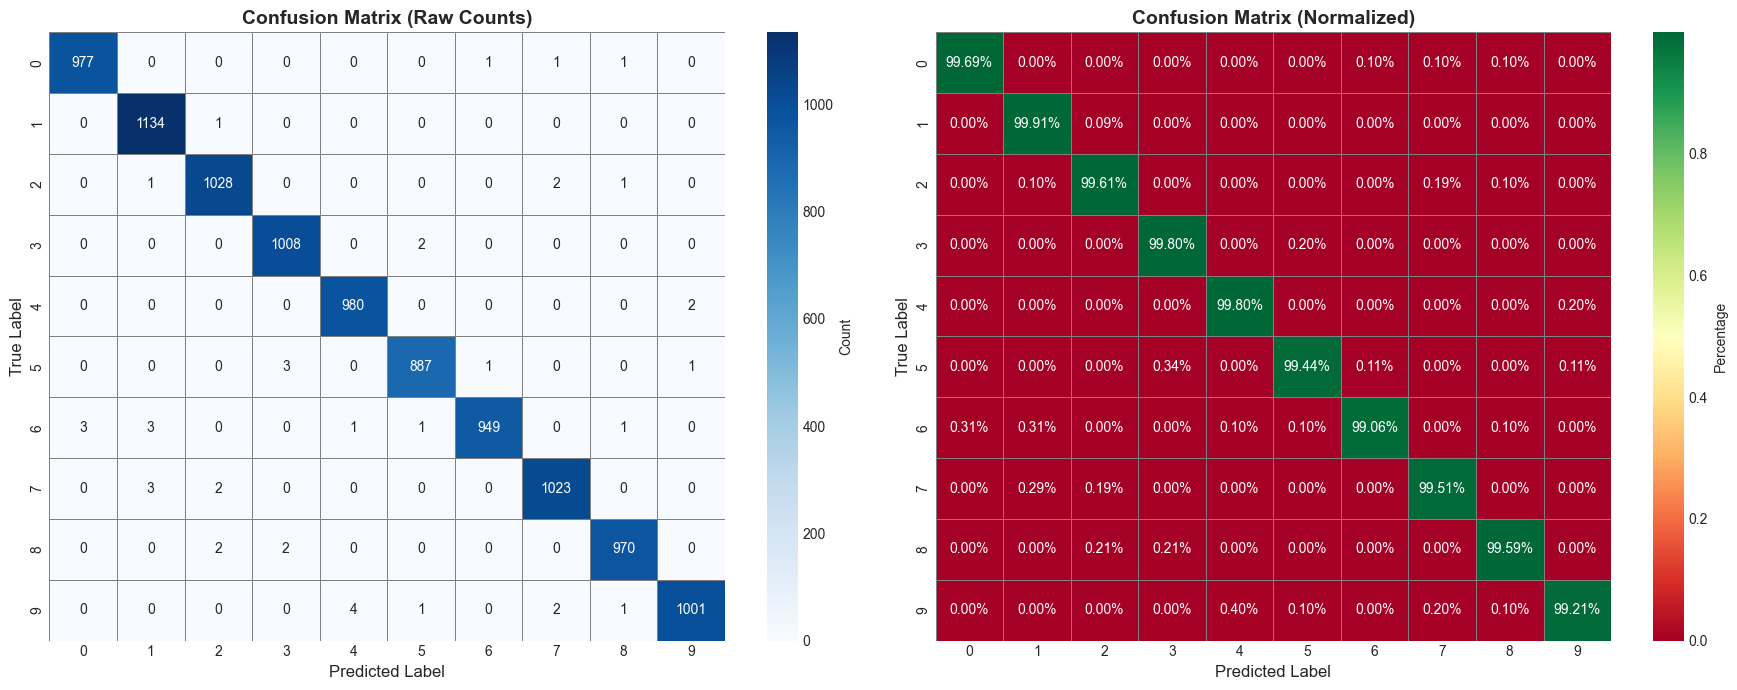


 Most Common Confusions:
   1. True: 9 → Predicted: 4 (4 times, 0.40%)
   2. True: 5 → Predicted: 3 (3 times, 0.34%)
   3. True: 6 → Predicted: 0 (3 times, 0.31%)
   4. True: 6 → Predicted: 1 (3 times, 0.31%)
   5. True: 7 → Predicted: 1 (3 times, 0.29%)


In [28]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            cbar_kws={'label': 'Count'}, linewidths=0.5, linecolor='gray')
ax1.set_title('Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicted Label', fontsize=12)
ax1.set_ylabel('True Label', fontsize=12)

# Normalized
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', ax=ax2,
            cbar_kws={'label': 'Percentage'}, linewidths=0.5, linecolor='gray')
ax2.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.savefig('outputs/confusion_matrix.png', dpi=300, bbox_inches='tight')
print(f" Confusion matrix saved to: outputs/confusion_matrix.png")
plt.show()

# Find top confusions
print(f"\n Most Common Confusions:")
confusion_pairs = []
for i in range(10):
    for j in range(10):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append((i, j, cm[i, j]))

confusion_pairs.sort(key=lambda x: x[2], reverse=True)

for idx, (true_label, pred_label, count) in enumerate(confusion_pairs[:5], 1):
    percentage = (count / cm[true_label].sum()) * 100
    print(f"   {idx}. True: {true_label} → Predicted: {pred_label} ({count} times, {percentage:.2f}%)")

## 11. Visualize Training History

**Simple Explanation:**
Let's make charts to see how the computer learned! We'll draw two graphs:
1. **Accuracy Graph**: Shows how often it guessed correctly (we want this going UP!)
2. **Loss Graph**: Shows how much it made mistakes (we want this going DOWN!)

If the lines for training and validation are close together, that's good! If they're far apart, the computer might have memorized instead of truly learning.

**Technical Explanation:**
Training history visualization helps diagnose:
- **Convergence**: Are metrics improving over time?
- **Overfitting**: Is there a gap between train and validation curves?
- **Underfitting**: Are both metrics still improving?
- **Optimal stopping**: When did performance plateau?


Available metrics: ['accuracy', 'loss', 'precision_2', 'recall_2', 'val_accuracy', 'val_loss', 'val_precision_2', 'val_recall_2', 'learning_rate']

 Training history saved to: outputs/training_history.png

 Training history saved to: outputs/training_history.png


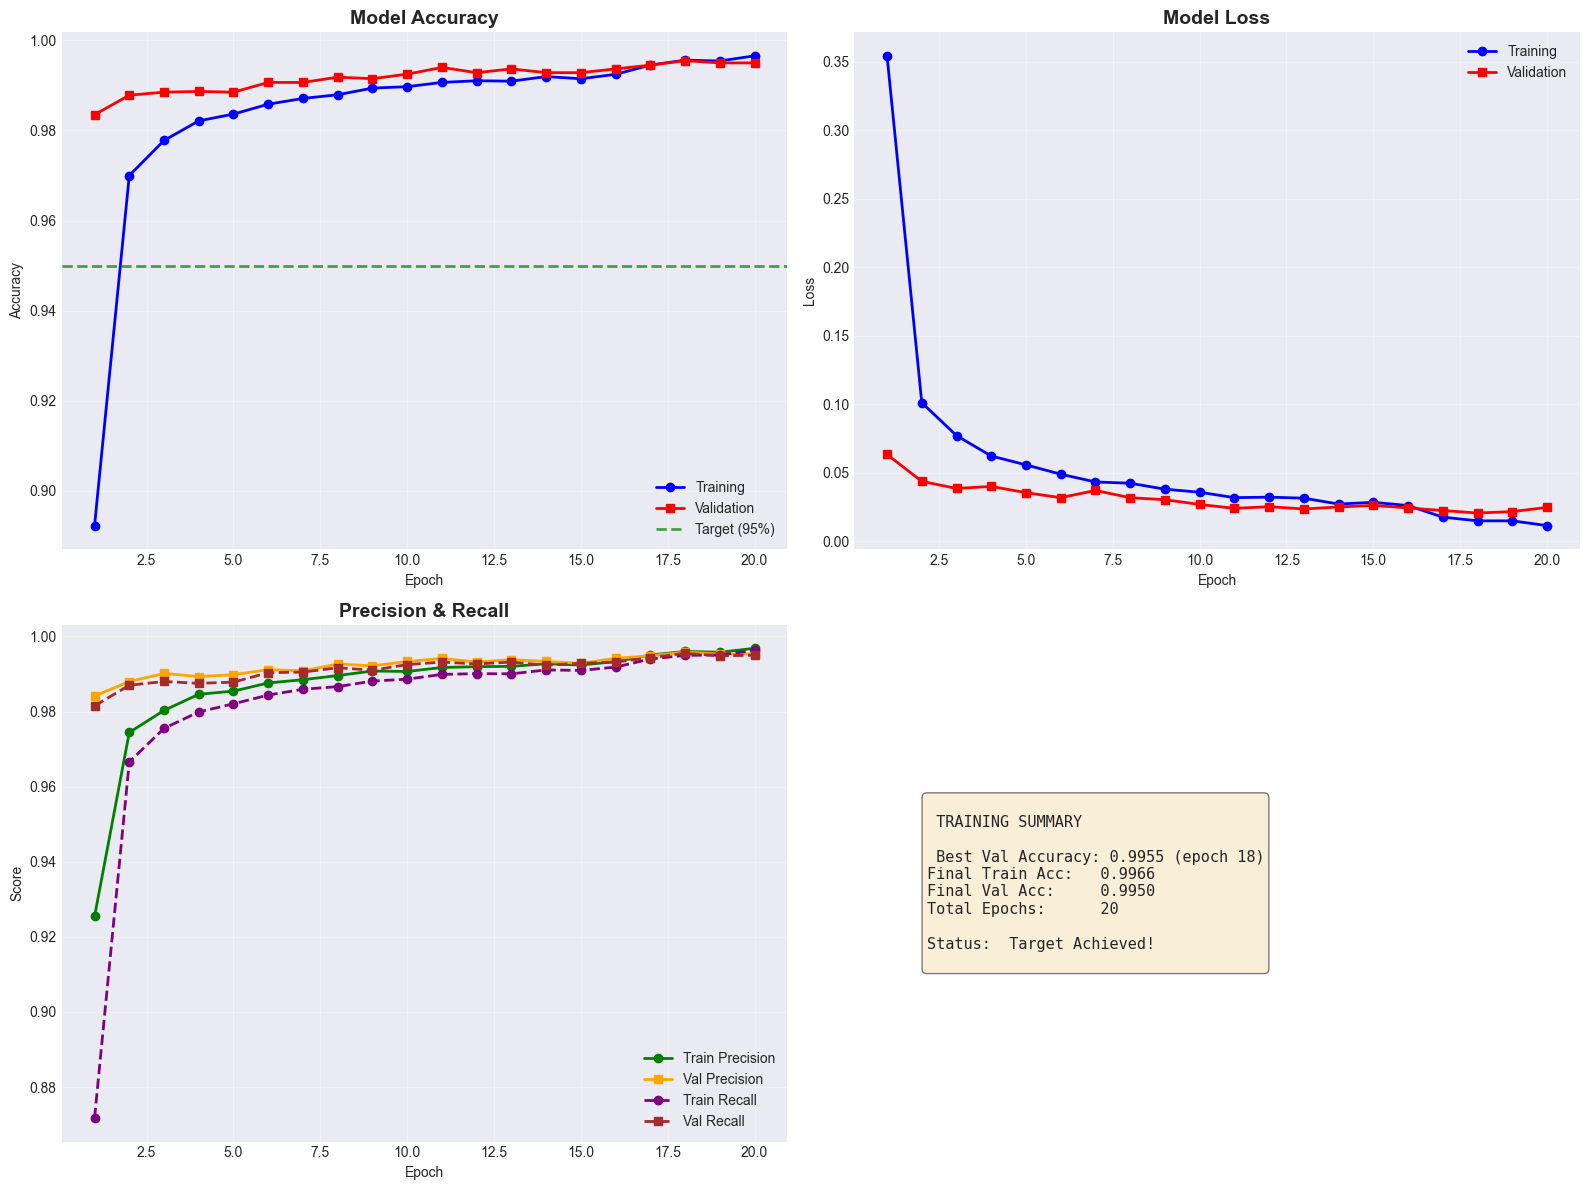

In [30]:
# Extract metrics
epochs_range = range(1, len(history.history['accuracy']) + 1)

# Check available metric names (for debugging)
print(f"\nAvailable metrics: {list(history.history.keys())}")

# Get the actual metric names (Keras may append numbers like 'precision_1', 'recall_1')
precision_key = [k for k in history.history.keys() if 'precision' in k and 'val' not in k][0]
val_precision_key = [k for k in history.history.keys() if 'val_precision' in k][0]
recall_key = [k for k in history.history.keys() if 'recall' in k and 'val' not in k][0]
val_recall_key = [k for k in history.history.keys() if 'val_recall' in k][0]

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy
ax1 = axes[0, 0]
ax1.plot(epochs_range, history.history['accuracy'], 'b-o', label='Training', linewidth=2)
ax1.plot(epochs_range, history.history['val_accuracy'], 'r-s', label='Validation', linewidth=2)
ax1.axhline(y=0.95, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Target (95%)')
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Loss
ax2 = axes[0, 1]
ax2.plot(epochs_range, history.history['loss'], 'b-o', label='Training', linewidth=2)
ax2.plot(epochs_range, history.history['val_loss'], 'r-s', label='Validation', linewidth=2)
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Precision and Recall (using actual metric names)
ax3 = axes[1, 0]
ax3.plot(epochs_range, history.history[precision_key], 'g-o', label='Train Precision', linewidth=2)
ax3.plot(epochs_range, history.history[val_precision_key], 'orange', marker='s', label='Val Precision', linewidth=2)
ax3.plot(epochs_range, history.history[recall_key], 'purple', marker='o', linestyle='--', label='Train Recall', linewidth=2)
ax3.plot(epochs_range, history.history[val_recall_key], 'brown', marker='s', linestyle='--', label='Val Recall', linewidth=2)
ax3.set_title('Precision & Recall', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Score')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Summary
ax4 = axes[1, 1]
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1

summary_text = f"""
 TRAINING SUMMARY

 Best Val Accuracy: {best_val_acc:.4f} (epoch {best_epoch})
Final Train Acc:   {history.history['accuracy'][-1]:.4f}
Final Val Acc:     {history.history['val_accuracy'][-1]:.4f}
Total Epochs:      {len(epochs_range)}

Status: {' Target Achieved!' if best_val_acc >= 0.95 else '⚠ Below Target'}
"""

ax4.text(0.1, 0.5, summary_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='center', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax4.axis('off')

plt.tight_layout()
plt.savefig('outputs/training_history.png', dpi=300, bbox_inches='tight')
print(f"\n Training history saved to: outputs/training_history.png")
plt.show()

## 12. Visualize Sample Predictions

Let's see the computer in action! We'll show some pictures and see what the computer thinks each number is. For each picture, we'll show:
- The actual handwritten digit
- What the computer guessed
- How confident it was (like being 99% sure vs 60% sure)

Green borders mean correct guesses, red borders mean mistakes!



C:\Users\Admin\AppData\Local\Temp\ipykernel_10184\1961453166.py:54: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_10184\1961453166.py:54: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_10184\1961453166.py:55: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.savefig('outputs/predictions_visualization.png', dpi=300, bbox_inches='tight')
C:\Users\Admin\AppData\Local\Temp\ipykernel_10184\1961453166.py:55: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig('outputs/predictions_visualization.png', dpi=300, bbox_inches='tight')
C:\Users\Admin\AppData\Local\Temp\ipykernel_10184\1961453166.py:55: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig('outputs/predictions_visualization.png', dpi=300, bbox_inches='tight')


 Predictions saved to: outputs/predictions_visualization.png


C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


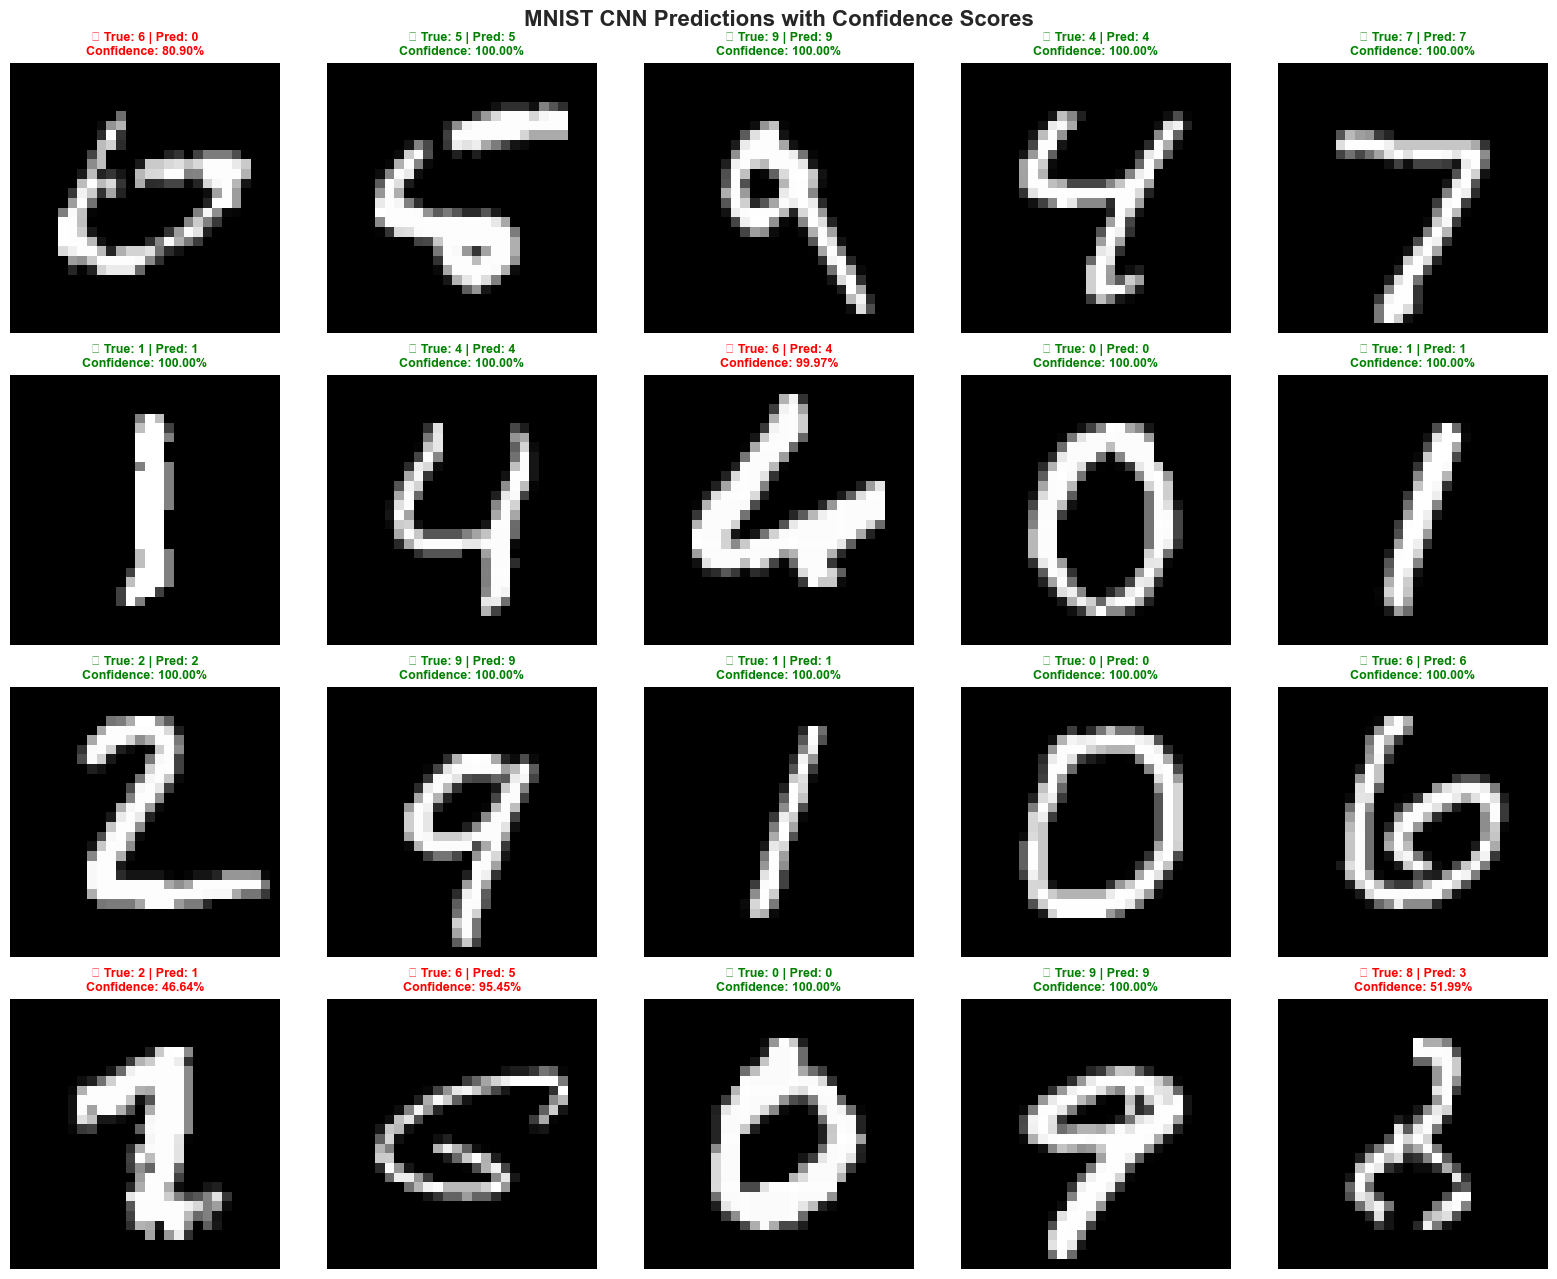


 Prediction Statistics:
   Avg Confidence: 99.80%
   Min Confidence: 45.06%
   Max Confidence: 100.00%


In [31]:
# Get confidence scores
confidence_scores = np.max(predictions, axis=1)

# Select diverse samples
correct_mask = y_true == y_pred
incorrect_mask = ~correct_mask

n_correct = min(15, correct_mask.sum())
n_incorrect = min(5, incorrect_mask.sum())

correct_indices = np.where(correct_mask)[0][:n_correct]
incorrect_indices = np.where(incorrect_mask)[0][:n_incorrect]

selected_indices = np.concatenate([correct_indices, incorrect_indices])
np.random.shuffle(selected_indices)
selected_indices = selected_indices[:20]

# Create visualization
fig, axes = plt.subplots(4, 5, figsize=(16, 13))
axes = axes.ravel()

for idx, ax in enumerate(axes):
    if idx < len(selected_indices):
        img_idx = selected_indices[idx]
        
        # Display image
        ax.imshow(X_test[img_idx].reshape(28, 28), cmap='gray')
        
        true_label = y_true[img_idx]
        pred_label = y_pred[img_idx]
        confidence = confidence_scores[img_idx]
        
        # Color based on correctness
        if true_label == pred_label:
            color = 'green'
            status = '✓'
        else:
            color = 'red'
            status = '✗'
        
        title = f'{status} True: {true_label} | Pred: {pred_label}\nConfidence: {confidence:.2%}'
        ax.set_title(title, fontsize=9, fontweight='bold', color=color)
        ax.axis('off')
        
        # Add border
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)
            spine.set_visible(True)
    else:
        ax.axis('off')

plt.suptitle('MNIST CNN Predictions with Confidence Scores', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/predictions_visualization.png', dpi=300, bbox_inches='tight')
print(f" Predictions saved to: outputs/predictions_visualization.png")
plt.show()

print(f"\n Prediction Statistics:")
print(f"   Avg Confidence: {confidence_scores.mean():.2%}")
print(f"   Min Confidence: {confidence_scores.min():.2%}")
print(f"   Max Confidence: {confidence_scores.max():.2%}")

## 13. Analyze Difficult Cases

Let's look at the pictures where the computer had the HARDEST time! Some handwritten numbers are messy or look like other numbers. We'll see which ones confused the computer and why. This helps us understand what the computer finds difficult, just like a teacher reviews mistakes with students!


 Difficulty Statistics:
   Total errors: 43 (0.43%)

 Top 10 Most Confident Mistakes:
   1. True: 7, Pred: 1, Conf: 100.00%
   2. True: 6, Pred: 1, Conf: 100.00%
   3. True: 4, Pred: 9, Conf: 100.00%
   4. True: 5, Pred: 6, Conf: 99.99%
   5. True: 6, Pred: 4, Conf: 99.97%
   6. True: 0, Pred: 7, Conf: 99.97%
   7. True: 7, Pred: 1, Conf: 99.91%
   8. True: 5, Pred: 3, Conf: 99.84%
   9. True: 2, Pred: 7, Conf: 99.82%
   10. True: 9, Pred: 4, Conf: 99.82%

 Difficult cases saved to: outputs/difficult_cases.png

 Difficult cases saved to: outputs/difficult_cases.png


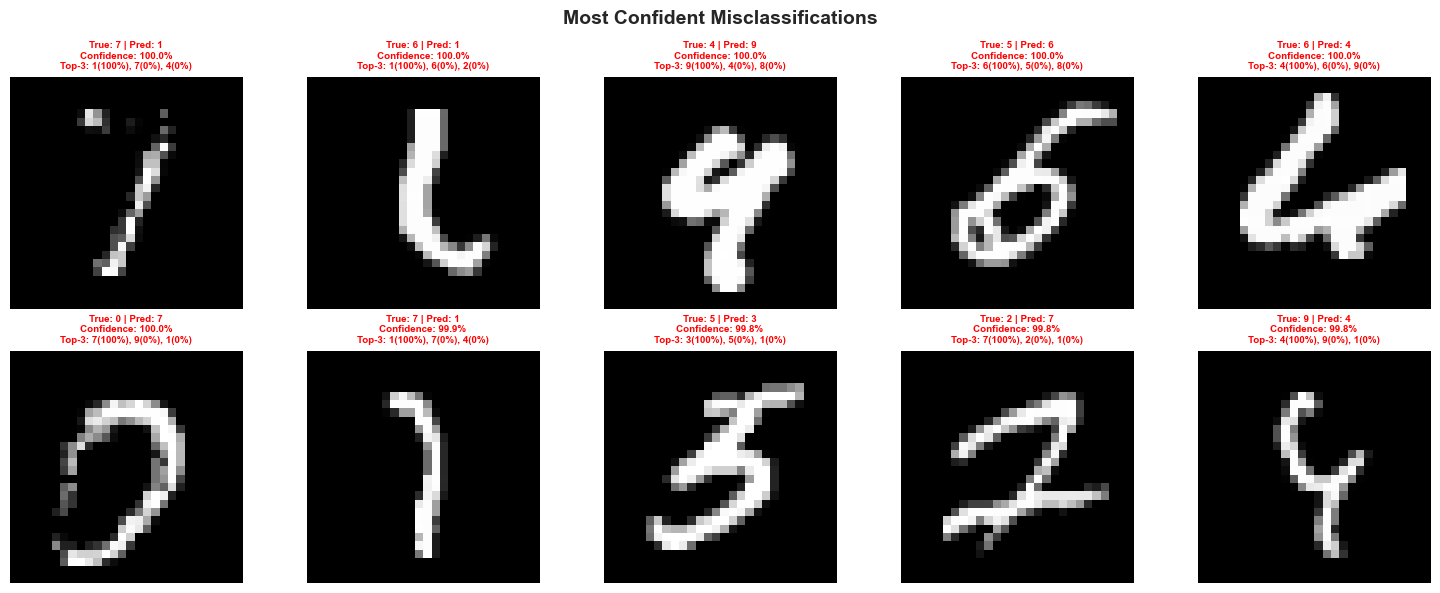

In [32]:
# Find incorrect predictions
incorrect_indices = np.where(incorrect_mask)[0]

print(f"\n Difficulty Statistics:")
print(f"   Total errors: {len(incorrect_indices)} ({len(incorrect_indices)/len(y_true)*100:.2f}%)")

if len(incorrect_indices) > 0:
    # Get worst predictions (most confident mistakes)
    worst_indices = incorrect_indices[np.argsort(-confidence_scores[incorrect_indices])][:10]
    
    print(f"\n Top 10 Most Confident Mistakes:")
    
    # Visualize
    n_cols = 5
    n_rows = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6))
    axes = axes.ravel()
    
    for idx, ax in enumerate(axes):
        if idx < len(worst_indices):
            img_idx = worst_indices[idx]
            
            ax.imshow(X_test[img_idx].reshape(28, 28), cmap='gray')
            
            true_label = y_true[img_idx]
            pred_label = y_pred[img_idx]
            confidence = confidence_scores[img_idx]
            
            # Get top 3 predictions
            top_3_idx = np.argsort(predictions[img_idx])[-3:][::-1]
            top_3_probs = predictions[img_idx][top_3_idx]
            
            title = f'True: {true_label} | Pred: {pred_label}\n'
            title += f'Confidence: {confidence:.1%}\n'
            title += f'Top-3: {top_3_idx[0]}({top_3_probs[0]:.0%}), '
            title += f'{top_3_idx[1]}({top_3_probs[1]:.0%}), '
            title += f'{top_3_idx[2]}({top_3_probs[2]:.0%})'
            
            ax.set_title(title, fontsize=7, color='red', fontweight='bold')
            ax.axis('off')
            
            print(f"   {idx+1}. True: {true_label}, Pred: {pred_label}, Conf: {confidence:.2%}")
        else:
            ax.axis('off')
    
    plt.suptitle('Most Confident Misclassifications', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('outputs/difficult_cases.png', dpi=300, bbox_inches='tight')
    print(f"\n Difficult cases saved to: outputs/difficult_cases.png")
    plt.show()
else:
    print(f"\n No misclassifications found!")

## 14. Save Model and Generate Final Report

We save the trained model in H5 format for future use. The final report summarizes all key metrics, training configuration, and model architecture for documentation and reproducibility purposes.

In [34]:
# Save model (using native Keras format)
model_path = 'outputs/saved_model/mnist_cnn_final.keras'
model.save(model_path)
print(f"\n Model saved to: {model_path}")

# Save weights (must use .weights.h5 extension)
weights_path = 'outputs/saved_model/model_weights.weights.h5'
model.save_weights(weights_path)
print(f" Weights saved to: {weights_path}")

# Generate report
report_path = 'outputs/model_report.txt'
with open(report_path, 'w') as f:
    f.write("=" * 80 + "\n")
    f.write("MNIST CNN MODEL - FINAL REPORT\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("1. MODEL ARCHITECTURE\n")
    f.write("=" * 80 + "\n")
    f.write(f"Total Parameters:       {model.count_params():,}\n")
    f.write(f"Input Shape:            (28, 28, 1)\n")
    f.write(f"Output Classes:         10\n\n")
    
    f.write("2. TRAINING CONFIGURATION\n")
    f.write("=" * 80 + "\n")
    f.write(f"Optimizer:              Adam (lr=0.001)\n")
    f.write(f"Loss Function:          Categorical Crossentropy\n")
    f.write(f"Batch Size:             64\n")
    f.write(f"Epochs:                 {len(history.history['loss'])}\n\n")
    
    f.write("3. FINAL PERFORMANCE\n")
    f.write("=" * 80 + "\n")
    f.write(f"Test Accuracy:          {test_accuracy:.4f} ({test_accuracy*100:.2f}%)\n")
    f.write(f"Test Precision:         {test_precision:.4f}\n")
    f.write(f"Test Recall:            {test_recall:.4f}\n")
    f.write(f"Test F1-Score:          {test_f1:.4f}\n")
    f.write(f"Target Achieved:        {'YES' if test_accuracy >= 0.95 else 'NO'}\n\n")
    
    f.write("4. PER-CLASS PERFORMANCE\n")
    f.write("=" * 80 + "\n")
    for digit in range(10):
        mask = y_true == digit
        digit_acc = (y_pred[mask] == digit).sum() / mask.sum()
        f.write(f"Digit {digit}: {digit_acc:.4f}\n")

print(f" Report saved to: {report_path}")

print(f"\n" + "=" * 70)
print("FINAL SUMMARY")
print("=" * 70)
print(f"\n Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f" All outputs saved to: outputs/")

if test_accuracy >= 0.95:
    print(f"\nTarget accuracy achieved!")
else:
    print(f"\nConsider additional training.")



 Model saved to: outputs/saved_model/mnist_cnn_final.keras
 Weights saved to: outputs/saved_model/model_weights.weights.h5
 Report saved to: outputs/model_report.txt

FINAL SUMMARY

 Test Accuracy: 0.9957 (99.57%)
 All outputs saved to: outputs/

Target accuracy achieved!
